✅ Dataset loaded with shape: (345, 44)
Columns: ['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Elapsed Time', 'Distance', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Filename', 'Athlete Weight', 'Moving Time', 'Max Speed', 'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High', 'Max Grade', 'Average Grade', 'Max Cadence', 'Average Cadence', 'Average Heart Rate', 'Average Watts', 'Calories', 'Average Temperature', 'Total Work', 'Weighted Average Power', 'Power Count', 'Average Elapsed Speed', 'Dirt Distance', 'Maximum Power 5s', 'Maximum Power 10s', 'Maximum Power 30s', 'Maximum Power 1.0min', 'Maximum Power 5.0min', 'Maximum Power 10.0min', 'Maximum Power 20.0min', 'Maximum Power 30.0min', 'Maximum Power 1.0 hr', 'Maximum Power 1.5 hr', 'Maximum Power 2.0 hr', 'Average Speed km/h', 'VO2 Max']
🎯 Selected target: VO2 Max
Dropped 0 rows with missing target. Remaining: 345

📊 Numeric summary (first 10 features):
                 cou

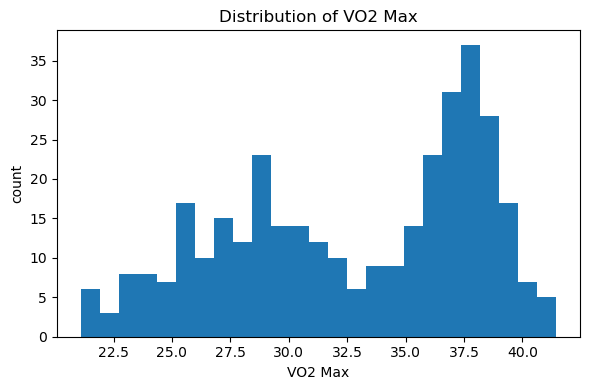

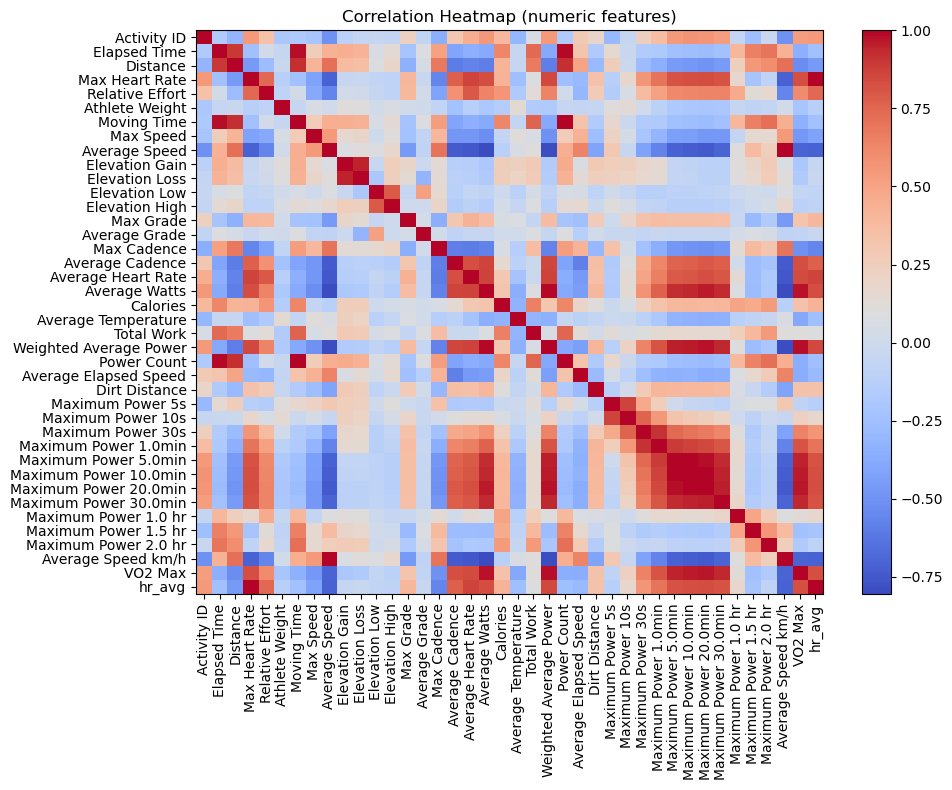


🔎 Evaluating LinearRegression...
R2 mean ± std: 0.9847 ± 0.0038
RMSE: 0.6581 | MAE: 0.4256

🔎 Evaluating RandomForest...
R2 mean ± std: 0.9942 ± 0.0023
RMSE: 0.4063 | MAE: 0.1922

🔎 Evaluating SVR...
R2 mean ± std: 0.9214 ± 0.0167
RMSE: 1.4924 | MAE: 0.9406

📋 Summary table:
              model   r2_mean    r2_std      rmse       mae
0      RandomForest  0.994183  0.002345  0.406282  0.192200
1  LinearRegression  0.984703  0.003821  0.658085  0.425562
2               SVR  0.921428  0.016687  1.492419  0.940552

🏆 Best model by CV R2: RandomForest


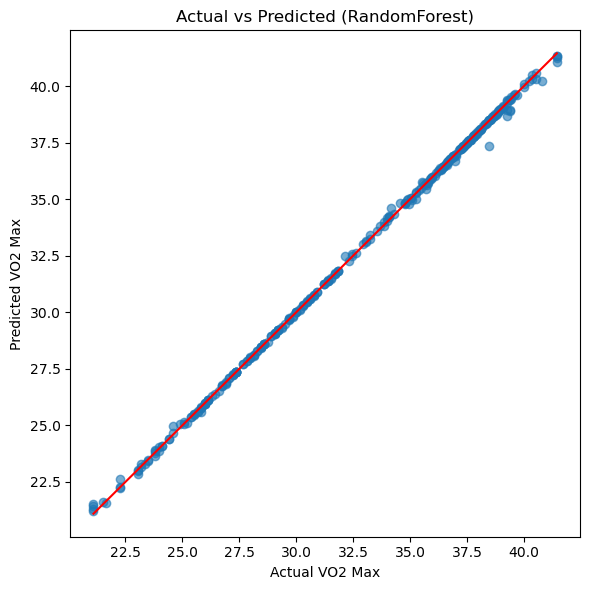

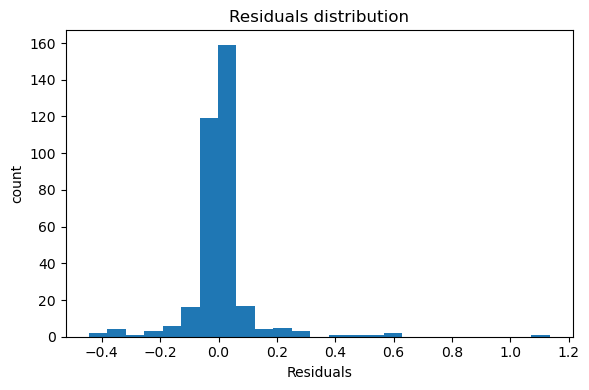

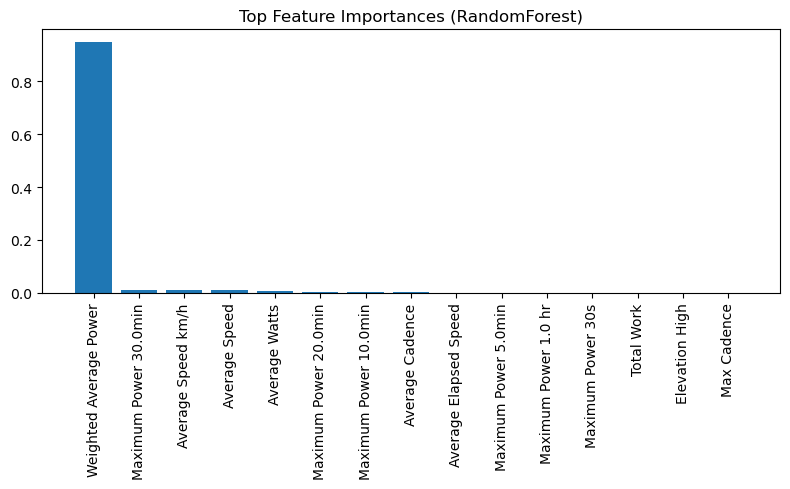

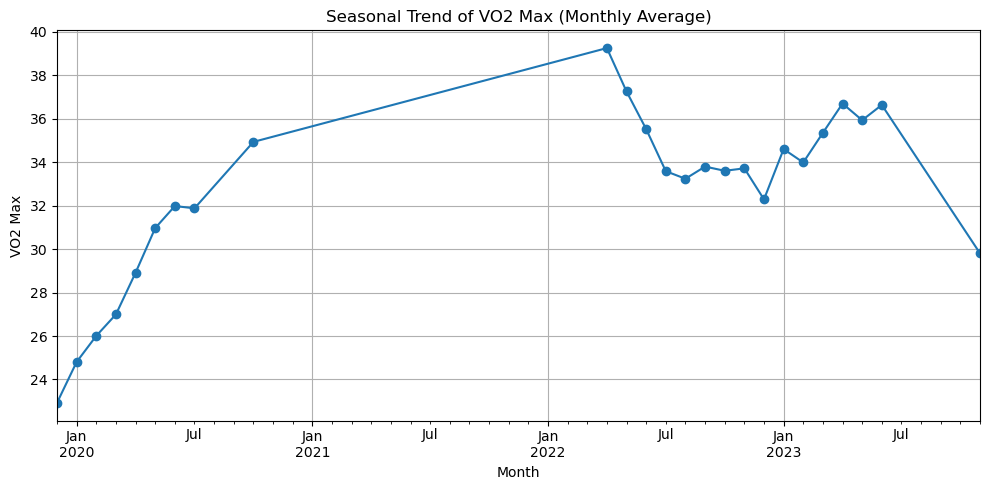


🔮 Sample predictions (first 10 rows):
     VO2 Max  pred_VO2 Max  resid_VO2 Max
0  22.243452     22.624051      -0.380598
1  21.508333     21.609933      -0.101599
2  21.096667     21.539502      -0.442835
3  24.595833     24.966002      -0.370169
4  21.096667     21.197295      -0.100629
5  23.046875     23.031024       0.015851
6  26.906250     26.832150       0.074100
7  28.604375     28.579675       0.024700
8  25.980000     25.952213       0.027787
9  22.275000     22.267894       0.007106


In [6]:
# ReflexionPro Data Analysis Pipeline (Full Graph Version)
# ========================================================
# Includes:
# - Data cleaning & preprocessing
# - Feature engineering
# - EDA with multiple plots
# - Cross-validation with multiple models
# - Best model evaluation
# - Graphs: distribution, correlation heatmap, actual vs predicted, residuals, feature importance, seasonal trend

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# -------------------
# 1) Load dataset
# -------------------
DATA_PATH = Path("simu_vo2_activities.csv")  

df = pd.read_csv(DATA_PATH)
print("✅ Dataset loaded with shape:", df.shape)
print("Columns:", df.columns.tolist())

# -------------------
# 2) Identify target
# -------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
candidate_targets = [c for c in df.columns if c.lower().replace(" ","") in ("vo2max","vo2","vo2_max")]
if not candidate_targets:
    candidate_targets = [c for c in df.columns if "vo2" in c.lower()]
if not candidate_targets:
    for pref in ["calories","kcal","energy","distance"]:
        match = [c for c in numeric_cols if pref in c.lower()]
        if match:
            candidate_targets = match
            break
if not candidate_targets and numeric_cols:
    candidate_targets = [numeric_cols[0]]

target = candidate_targets[0]
print("🎯 Selected target:", target)

# -------------------
# 3) Basic cleaning
# -------------------
df_clean = df.copy()
for col in df_clean.columns:
    if "date" in col.lower():
        try:
            df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        except Exception:
            pass

rows_before = len(df_clean)
df_clean = df_clean[~df_clean[target].isnull()].reset_index(drop=True)
rows_after = len(df_clean)
print(f"Dropped {rows_before-rows_after} rows with missing target. Remaining: {rows_after}")

q_low, q_high = df_clean[target].quantile([0.01, 0.99])
df_clean[target] = df_clean[target].clip(lower=q_low, upper=q_high)

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_clean.select_dtypes(include=['object','category']).columns.tolist()
if target in num_cols:
    num_cols.remove(target)

df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())
df_clean[cat_cols] = df_clean[cat_cols].fillna("missing")

# -------------------
# 4) Feature Engineering
# -------------------
if 'Elapsed Time' in df_clean.columns and df_clean['Elapsed Time'].dtype == object:
    try:
        df_clean['Elapsed Time'] = pd.to_timedelta(df_clean['Elapsed Time']).dt.total_seconds()
    except Exception:
        pass

hr_cols = [c for c in df_clean.columns if "hr" in c.lower() or "heart" in c.lower()]
if hr_cols:
    hr_col = hr_cols[0]
    df_clean['hr_avg'] = pd.to_numeric(df_clean[hr_col], errors='coerce').fillna(df_clean[hr_col].median())

# -------------------
# 5) EDA Plots
# -------------------
print("\n📊 Numeric summary (first 10 features):")
print(df_clean.describe().T.head(10))

# Distribution of target
plt.figure(figsize=(6,4))
plt.hist(df_clean[target].dropna(), bins=25)
plt.title(f"Distribution of {target}")
plt.xlabel(target)
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = df_clean.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,8))
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

# -------------------
# 6) Features for modeling
# -------------------
features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target in features:
    features.remove(target)
small_cats = [c for c in df_clean.select_dtypes(include=['object','category']).columns if df_clean[c].nunique() <= 20]
features += small_cats
features = list(dict.fromkeys(features))

X = df_clean[features].copy()
y = df_clean[target].values

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
], remainder='drop')

# -------------------
# 7) Models
# -------------------
models = {
    "LinearRegression": Pipeline([("pre", preprocessor), ("model", LinearRegression())]),
    "RandomForest": Pipeline([("pre", preprocessor), ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1))]),
    "SVR": Pipeline([("pre", preprocessor), ("model", SVR(kernel='rbf', C=1.0, gamma='scale'))])
}

# -------------------
# 8) Cross-validation
# -------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
summary = []
for name, pipe in models.items():
    print(f"\n🔎 Evaluating {name}...")
    r2_scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2', n_jobs=1)
    y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    print(f"R2 mean ± std: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")
    summary.append({"model": name, "r2_mean": r2_scores.mean(), "r2_std": r2_scores.std(), "rmse": rmse, "mae": mae})

summary_df = pd.DataFrame(summary).sort_values(by="r2_mean", ascending=False).reset_index(drop=True)
print("\n📋 Summary table:")
print(summary_df)

# -------------------
# 9) Best model evaluation
# -------------------
best_name = summary_df.loc[0,'model']
print("\n🏆 Best model by CV R2:", best_name)
best_pipe = models[best_name]
best_pipe.fit(X, y)
df_clean['pred_'+target] = best_pipe.predict(X)
df_clean['resid_'+target] = df_clean[target] - df_clean['pred_'+target]

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(df_clean[target], df_clean['pred_'+target], alpha=0.6)
mn = min(df_clean[target].min(), df_clean['pred_'+target].min())
mx = max(df_clean[target].max(), df_clean['pred_'+target].max())
plt.plot([mn,mx],[mn,mx], color="red")
plt.xlabel("Actual " + target)
plt.ylabel("Predicted " + target)
plt.title(f"Actual vs Predicted ({best_name})")
plt.tight_layout()
plt.show()

# Residuals distribution
plt.figure(figsize=(6,4))
plt.hist(df_clean['resid_'+target], bins=25)
plt.title("Residuals distribution")
plt.xlabel("Residuals")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Feature importance (if RandomForest is best)
if best_name == "RandomForest":
    model = best_pipe.named_steps["model"]
    importances = model.feature_importances_
    feature_names = best_pipe.named_steps["pre"].transformers_[0][2] + list(
        best_pipe.named_steps["pre"].transformers_[1][1].named_steps["onehot"].get_feature_names_out(categorical_features)
        if categorical_features else []
    )
    sorted_idx = np.argsort(importances)[::-1][:15]
    plt.figure(figsize=(8,5))
    plt.bar(range(len(sorted_idx)), importances[sorted_idx])
    plt.xticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx], rotation=90)
    plt.title("Top Feature Importances (RandomForest)")
    plt.tight_layout()
    plt.show()

# Seasonal trend plot if Activity Date exists
if "Activity Date" in df_clean.columns:
    df_clean['month'] = df_clean['Activity Date'].dt.to_period("M")
    monthly = df_clean.groupby('month')[target].mean()
    plt.figure(figsize=(10,5))
    monthly.plot(marker="o")
    plt.title(f"Seasonal Trend of {target} (Monthly Average)")
    plt.xlabel("Month")
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------
# 10) Show sample predictions
# -------------------
print("\n🔮 Sample predictions (first 10 rows):")
print(df_clean[[target, 'pred_'+target, 'resid_'+target]].head(10))
